In [1]:
import pandas as pd
import numpy as np
import sklearn
import time
import pickle
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.utils import resample
from tabgan.sampler import OriginalGenerator, GANGenerator

In [2]:
def load_model():
    try:
        with open("bestModel.pickle", "rb") as f:
            model, accuracy, X_test, y_test = pickle.load(f)
            f.close
        load_model.best = accuracy
        return model, accuracy, X_test, y_test
    except OSError:
        load_model.best = 0
        print("No trained model found")
        pass
    
load_model()
best = load_model.best

In [3]:
def resampling(df, s):
    normal_df = resample(df.loc[df['BMI']==0], replace=True, n_samples=s)
    obese_df = resample(df.loc[df['BMI']==1], replace=True, n_samples=s)
    overweight_df = resample(df.loc[df['BMI']==2], replace=True, n_samples=s)
    underweight_df = resample(df.loc[df['BMI']==3], replace=True, n_samples=s)
    df = pd.DataFrame(columns=['CJWR', 'WHR', 'PAR', 'ES', 'LF/FH', 'FW/LFH', 'MEH', 'BMI'])
    df = underweight_df.append(overweight_df.append(obese_df.append(normal_df, ignore_index=True), ignore_index=True), ignore_index=True)
    df = df.dropna(how='any', inplace=False)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [4]:
def data_split(df):
    X = df.loc[:, df.columns != 'BMI']
    y = df.loc[:, df.columns == 'BMI']
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [5]:
def generate_data1(X_train, y_train, X_test):
    X_train_new1, y_train_new1 = GANGenerator(gen_x_times=3.0, 
                                              cat_cols=None, 
                                              bot_filter_quantile=0.001, 
                                              top_filter_quantile=0.999, 
                                              is_post_process=True, 
                                              adversarial_model_params={"metrics": "AUC", 
                                                                        "max_depth": 2, 
                                                                        "max_bin": 100, 
                                                                        "learning_rate": 0.01, 
                                                                        "n_estimators": 500,}, 
                                              pregeneration_frac=2, 
                                              only_generated_data=False, 
                                              gan_params = {"batch_size": 20, 
                                                            "patience": 25, 
                                                            "epochs" : 200,}
                                             ).generate_data_pipe(X_train, 
                                                                  y_train, 
                                                                  X_test, 
                                                                  deep_copy=True, 
                                                                  only_adversarial=False, 
                                                                  use_adversarial=True)
    return X_train_new1, y_train_new1

In [6]:
def generate_data2(X_train, y_train, X_test):
    X_train_new2, y_train_new2 = OriginalGenerator().generate_data_pipe(X_train, y_train, X_test,)
    return X_train_new2, y_train_new2

In [7]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.astype(np.float32))
    X_test = scaler.transform(X_test.astype(np.float32))
    return X_train, X_test

In [8]:
def train(X_train, y_train, X_test, y_test, best):
    grid_param = {'C': [0.1,1, 10, 100], 
                  'gamma': [1,0.1,0.01,0.001], 
                  'kernel': ['rbf', 'poly', 'sigmoid']}

    clf = GridSearchCV(svm.SVC(), 
                       grid_param, 
                       refit=True, 
                       verbose=3)
        
    X_train, X_test = scale_data(X_train, X_test)

    model = clf.fit(X_train, y_train.values.ravel())

    accuracy = model.score(X_test, y_test)
    print(f"MODEL ACCURACY: {round(accuracy * 100, 2)}%")

    if accuracy > best:
        best = accuracy
        with open("bestModel.pickle", "wb") as f:
            pickle.dump([model, accuracy, X_test, y_test], f)
            f.close

In [9]:
normal_df = pd.read_csv("training_dataset/normal_dataset.csv")
normal_df = normal_df.dropna(how='any', inplace=False)
obese_df = pd.read_csv("training_dataset/obese_dataset.csv")
obese_df = obese_df.dropna(how='any', inplace=False)
overweight_df = pd.read_csv("training_dataset/overweight_dataset.csv")
overweight_df = overweight_df.dropna(how='any', inplace=False)
underweight_df = pd.read_csv("training_dataset/underweight_dataset.csv")
underweight_df = underweight_df.dropna(how='any', inplace=False)
normal_df['BMI'] = 0
obese_df['BMI'] = 1
overweight_df['BMI'] = 2
underweight_df['BMI'] = 3

In [10]:
print("normal =", len(normal_df))
print("obese =", len(obese_df))
print("overweight =", len(overweight_df))
print("underweight =", len(underweight_df))

normal = 100
obese = 43
overweight = 77
underweight = 39


In [11]:
normal_df

,CJWR,WHR,PAR,ES,LF/FH,FW/LFH,MEH,BMI
0,1.143361,1.572091,7.776422,0.133180,0.706329,1.209493,0.064144,0
1,1.229513,1.335293,7.554033,0.145534,0.683206,1.263953,0.092514,0
2,1.174608,1.514006,7.926561,0.136975,0.693700,1.246039,0.078190,0
3,1.171522,1.494237,7.567708,0.138782,0.714710,1.174141,0.081913,0
4,1.184748,1.460178,7.916351,0.134939,0.689374,1.254548,0.073121,0
...,...,...,...,...,...,...,...,...
95,1.171745,1.357832,7.372447,0.135446,0.728828,1.127040,0.080013,0
96,1.192724,1.529733,7.743752,0.141236,0.704549,1.276994,0.076253,0
97,1.186700,1.398413,7.341549,0.135928,0.721358,1.155739,0.089987,0
98,1.156033,1.514058,7.280071,0.135818,0.729467,1.163792,0.069407,0


In [12]:
obese_df

,CJWR,WHR,PAR,ES,LF/FH,FW/LFH,MEH,BMI
0,1.197853,1.365109,7.976240,0.132233,0.703432,1.218353,0.085237,1
1,1.143468,1.530981,7.104798,0.144387,0.723775,1.226173,0.081954,1
2,1.162925,1.419480,7.265666,0.133399,0.718395,1.132728,0.078293,1
3,1.159536,1.600080,7.551637,0.138037,0.708106,1.213932,0.077189,1
4,1.156497,1.432772,7.110258,0.137753,0.733981,1.134666,0.083970,1
5,1.133025,1.772985,8.035507,0.139182,0.715099,1.232309,0.069885,1
6,1.182167,1.535942,7.889314,0.136987,0.691332,1.241269,0.080116,1
7,1.159889,1.383987,7.638382,0.131615,0.705961,1.155146,0.084981,1
8,1.166065,1.733759,8.449405,0.134227,0.694098,1.239307,0.066874,1
9,1.177837,1.566080,7.629820,0.139542,0.703257,1.214540,0.075526,1


In [13]:
overweight_df

,CJWR,WHR,PAR,ES,LF/FH,FW/LFH,MEH,BMI
0,1.138470,1.571986,7.145570,0.140064,0.752659,1.183964,0.082256,2
1,1.172632,1.298329,6.959777,0.139308,0.725698,1.101722,0.085601,2
2,1.159304,1.628842,8.300374,0.137062,0.685561,1.256644,0.071448,2
3,1.154399,1.609611,7.472209,0.141177,0.713788,1.204189,0.079392,2
4,1.163319,1.436310,7.136131,0.142065,0.702740,1.180596,0.080825,2
...,...,...,...,...,...,...,...,...
72,1.171350,1.705043,8.055369,0.137550,0.699411,1.263490,0.073194,2
73,1.165609,1.349451,7.217469,0.134018,0.732184,1.110148,0.080841,2
74,1.140595,1.540569,6.988356,0.137333,0.741266,1.160475,0.083119,2
75,1.130798,1.597680,7.285057,0.135896,0.726911,1.195601,0.088608,2


In [14]:
underweight_df

,CJWR,WHR,PAR,ES,LF/FH,FW/LFH,MEH,BMI
0,1.173954,1.502008,7.431153,0.139064,0.727646,1.247570,0.086885,3
1,1.217456,1.334965,7.803711,0.137448,0.693065,1.210357,0.085020,3
2,1.182257,1.461462,7.636605,0.137833,0.692568,1.217440,0.089682,3
3,1.202312,1.501998,7.847809,0.139129,0.694290,1.226325,0.076303,3
4,1.222238,1.404705,7.573076,0.145406,0.686912,1.259289,0.088394,3
5,1.192583,1.495202,7.617638,0.140664,0.701305,1.242230,0.077098,3
6,1.150938,1.686358,7.915176,0.138187,0.684399,1.279148,0.080947,3
7,1.201103,1.293100,7.388139,0.138142,0.698790,1.147699,0.090807,3
8,1.215266,1.460822,7.982457,0.140025,0.683645,1.222498,0.078533,3
9,1.152213,1.577914,7.570710,0.140744,0.700880,1.192344,0.077310,3


In [15]:
df_orig = underweight_df.append(overweight_df.append(obese_df.append(normal_df, ignore_index=True), ignore_index=True), ignore_index=True)
df = resampling(df_orig, 40)
df = df.dropna(how='any', inplace=False)
df

,CJWR,WHR,PAR,ES,LF/FH,FW/LFH,MEH,BMI
0,1.182808,1.384880,7.414344,0.139563,0.697143,1.203198,0.077089,0
1,1.162042,1.529874,7.372811,0.135198,0.718142,1.159372,0.087965,0
2,1.180022,1.562321,7.529468,0.139337,0.722045,1.161626,0.078646,0
3,1.253487,1.344168,8.578411,0.136819,0.660055,1.287254,0.077651,0
4,1.221238,1.382647,8.381452,0.138171,0.670022,1.271087,0.081482,0
...,...,...,...,...,...,...,...,...
155,1.152241,1.576822,7.876115,0.136755,0.694217,1.178660,0.089261,3
156,1.185447,1.560886,8.040294,0.135289,0.693212,1.273334,0.075406,2
157,1.126572,1.629684,7.443339,0.129720,0.753068,1.067881,0.072221,2
158,1.166054,1.591959,7.094794,0.143893,0.724750,1.214951,0.077820,1


In [16]:
df['BMI'].value_counts()

0    40
1    40
2    40
3    40
Name: BMI, dtype: int64

In [17]:
start1 = time.time()

count = 1

for i in range(count):
    df = resampling(df_orig, 40)
    df = df.dropna(how='any', inplace=False)
    X_train, X_test, y_train, y_test = data_split(df)
    train(X_train, y_train, X_test, y_test, best)
    
    df = resampling(df_orig, 40)
    df = df.dropna(how='any', inplace=False)
    X_train, X_test, y_train, y_test = data_split(df)
    X_train_new1, y_train_new1 = generate_data1(X_train, y_train, X_test)
    df = X_train_new1
    df['BMI'] = y_train_new1
    df = resampling(df, 60)
    X_train = df.loc[:, df.columns != 'BMI']
    y_train = df.loc[:, df.columns == 'BMI']
    train(X_train, y_train, X_test, y_test, best)
    
    df = resampling(df_orig, 40)
    df = df.dropna(how='any', inplace=False)
    X_train, X_test, y_train, y_test = data_split(df)
    X_train_new2, y_train_new2 = generate_data2(X_train, y_train, X_test)
    df = X_train_new2
    df['BMI'] = y_train_new2
    df = resampling(df, 60)
    X_train = df.loc[:, df.columns != 'BMI']
    y_train = df.loc[:, df.columns == 'BMI']
    train(X_train, y_train, X_test, y_test, best)
    
stop1 = time.time()

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.269, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.269, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.269, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.280, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.280, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.423, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........... C=1, gamma=1, kernel=poly, score=0.538, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.615, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.462, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.720, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.560, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ........ C=1, gamma=1, kernel=sigmoid, score=0.154, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ........ C=1, gamma=1, kernel=sigmoid, score=0.346, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.6s finished


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/200 [00:00<?, ?it/s]

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.479, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.729, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.479, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.479, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.604, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.312, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.271, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.354, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.292, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.167, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.312, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.292, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.854, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.708, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.854, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.875, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.771, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.979, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ... C=0.1, gamma=0.01, kernel=sigmoid, score=0.521, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=0.1, gamma=0.01, kernel=sigmoid, score=0.479, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=0.1, gamma=0.01, kernel=sigmoid, score=0.521, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=0.1, gamma=0.01, kernel=sigmoid, score=0.667, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=0.1, gamma=0.01, kernel=sigmoid, score=0.479, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.521, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.479, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.9s finished


BEST SVM PARAMETERS:
SVC(C=10, gamma=1, kernel='poly')

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       1.00      1.00      1.00         9
           2       0.80      0.80      0.80         5
           3       0.90      0.90      0.90        10

    accuracy                           0.91        32
   macro avg       0.89      0.89      0.89        32
weighted avg       0.91      0.91      0.91        32

MODEL ACCURACY: 90.62%

CONFUSION MATRIX:

0 = NORMAL
1 = OBESE
2 = OVERWEIGHT
3 = UNDERWEIGHT


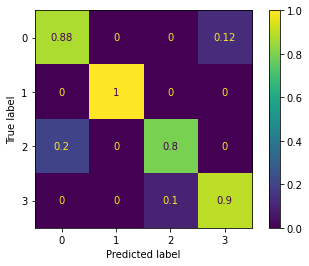

In [18]:
model, accuracy, X_test, y_test = load_model()
y_pred = model.predict(X_test)

classification_report = classification_report(y_test, y_pred)
accuracy = model.score(X_test, y_test)

disp = plot_confusion_matrix(model, X_test, y_test, normalize='true')
disp.plot

print("BEST SVM PARAMETERS:")
print(model.best_estimator_)
print()
print("CLASSIFICATION REPORT")
print(classification_report)
print(f"MODEL ACCURACY: {round(accuracy * 100, 2)}%")
print()
print("CONFUSION MATRIX:")
print()
print("0 = NORMAL")
print("1 = OBESE")
print("2 = OVERWEIGHT")
print("3 = UNDERWEIGHT")